In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import string
import re

import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet

import scipy
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,auc,f1_score
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data

import torchsummary

import time
import os
import shutil

from tqdm.notebook import tqdm
tqdm.pandas()

In [4]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yoyo1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yoyo1\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yoyo1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Load Datasets
1. Load the datasets
2. Verify no article bodies overlap

In [5]:
train_stances = pd.read_csv("./dataset/train_stances.csv")
train_bodies = pd.read_csv("./dataset/train_bodies.csv")

test_stances = pd.read_csv("./dataset/competition_test_stances.csv")
test_bodies = pd.read_csv("./dataset/competition_test_bodies.csv")

In [6]:
train_stances["Headline"].value_counts()

ISIL Beheads American Photojournalist in Iraq                                                      127
WHO says reports of suspected Ebola cases in Iraq are untrue                                       124
James Foley remembered as 'brave and tireless' journalist                                          121
Islamic Militants Post Video Claiming to Show Beheading of U.S. Journalist                         118
US officials: Video shows American's execution                                                     112
                                                                                                  ... 
Apple hopes to sell over 50 million watches in 2015                                                  2
Mom Calls 911 On Masturbating Teenage Son; Boy Arrested, Charged With New ‘Self-Rape’ State Law      2
Federal Judge: Enough With the Stupid Names                                                          2
Sushi lover's entire body left riddled with WORMS after eating contaminat

In [7]:
test_stances["Headline"].value_counts()

Source: Joan Rivers' doc did biopsy, selfie                                                                                                                  160
Joan Rivers Personal Doctor Allegedly Took A Selfie Before Her Biopsy And Cardiac Arrest                                                                     138
‘Three-boobed’ woman: They’re not fake                                                                                                                        92
Adopting Potential Werewolves Is Routine Business for Argentine Presidents                                                                                    92
Justin Bieber Basically Saves A Russian Man From A Bear                                                                                                       88
                                                                                                                                                            ... 
Madonna pledges oral sex for Clint

In [8]:
train_stances.loc[train_stances["Headline"].isin(test_stances["Headline"])]

,Headline,Body ID,Stance
173,Cheese addiction breaks Kim Jong-un's ankles,2210,unrelated
1415,WSJ: Apple cut watch health features due to er...,1917,discuss
1418,Cheese blamed for North Korean leader Kim Jong...,1689,unrelated
1479,Cheese blamed for North Korean leader Kim Jong...,186,unrelated
1503,Cheese addiction breaks Kim Jong-un's ankles,2329,unrelated
...,...,...,...
48270,Apple was forced to nix key health features fr...,407,discuss
48852,Cheese blamed for North Korean leader Kim Jong...,2042,unrelated
49279,Cheese addiction breaks Kim Jong-un's ankles,1854,discuss
49349,Cheese blamed for North Korean leader Kim Jong...,2344,unrelated


In [9]:
train_stances.loc[train_stances["Body ID"].isin(test_stances["Body ID"])]

,Headline,Body ID,Stance


So there is overlap of the headlines in both the training and the test data but there is no overlap with the bodies of the articles so we should split the training set into training and validation such that the bodies of the articles are disjoint.

In [10]:
test_df = test_stances.merge(test_bodies, on="Body ID")
test_df["Related"] = (test_df["Stance"] != "unrelated").astype(int)

In [11]:
test_df

,Headline,Body ID,Stance,articleBody,Related
0,Ferguson riots: Pregnant woman loses eye after...,2008,unrelated,A RESPECTED senior French police officer inves...,0
1,Apple Stores to install safes to secure gold A...,2008,unrelated,A RESPECTED senior French police officer inves...,0
2,Pregnant woman loses eye after police shoot be...,2008,unrelated,A RESPECTED senior French police officer inves...,0
3,We just found out the #Ferguson Protester who ...,2008,unrelated,A RESPECTED senior French police officer inves...,0
4,Police Chief In Charge of Paris Attacks Commit...,2008,discuss,A RESPECTED senior French police officer inves...,1
...,...,...,...,...,...
25408,A Sign That Obamacare Exchanges Are Failing,2586,disagree,Remember how much Republicans wanted to repeal...,1
25409,Republicans call Obamacare a 'failure.' These ...,2586,agree,Remember how much Republicans wanted to repeal...,1
25410,CBO’s Alternate Facts Show Obamacare is Unsust...,2586,disagree,Remember how much Republicans wanted to repeal...,1
25411,Why Obamacare failed,2586,disagree,Remember how much Republicans wanted to repeal...,1


In [12]:
train_and_val_df = train_stances.merge(train_bodies, on="Body ID")
train_and_val_df["Related"] = (train_and_val_df["Stance"] != "unrelated").astype(int)

# Exploratory Data Analysis
TODO: Data analysis

In [13]:
train_and_val_df

,Headline,Body ID,Stance,articleBody,Related
0,Police find mass graves with at least '15 bodi...,712,unrelated,Danny Boyle is directing the untitled film\r\n...,0
1,Seth Rogen to Play Apple’s Steve Wozniak,712,discuss,Danny Boyle is directing the untitled film\r\n...,1
2,Mexico police find mass grave near site 43 stu...,712,unrelated,Danny Boyle is directing the untitled film\r\n...,0
3,Mexico Says Missing Students Not Found In Firs...,712,unrelated,Danny Boyle is directing the untitled film\r\n...,0
4,New iOS 8 bug can delete all of your iCloud do...,712,unrelated,Danny Boyle is directing the untitled film\r\n...,0
...,...,...,...,...,...
49967,Amazon Is Opening a Brick-and-Mortar Store in ...,464,agree,"Amazon, the cyber store that sells everything,...",1
49968,Elon University has not banned the term ‘fresh...,362,agree,"ELON, N.C. – A recent rumor claims that Elon U...",1
49969,Fake BBC News website set up to carry Charlie ...,915,agree,A realistic-looking fake BBC News website has ...,1
49970,Apple was forced to nix key health features fr...,407,discuss,The health-focused smartwatch that Apple initi...,1


# Data Splitting
Now we need to split the training data into a training and validation set. We leave the test set untouched in this respect.

In [14]:
val_split_ratio = 0.2

In [15]:
def split_train_val(df, ratio):
    val_count = int(ratio * df["Body ID"].nunique())
    all_ids = list(df["Body ID"].unique())
    val_body_ids = random.sample(all_ids, val_count)
    train_body_ids = set(all_ids) - set(val_body_ids)
    
    assert len(set(val_body_ids) & train_body_ids) == 0
    
    val_df = df.loc[df["Body ID"].isin(val_body_ids)]
    train_df = df.loc[df["Body ID"].isin(train_body_ids)]
    
    return val_df, train_df

In [16]:
val_df, train_df = split_train_val(train_and_val_df, val_split_ratio)

In [17]:
val_df["Body ID"].nunique()

336

In [18]:
test_df["Body ID"].nunique()

904

In [19]:
train_df["Body ID"].nunique()

1347

In [20]:
def prepare_df(df):
    df = df.drop("Body ID", axis=1)
    df = df.reset_index()
    df = df.drop("index", axis=1)
    df["Related"] = df["Stance"] != "unrelated"
    return df

In [21]:
val_df = prepare_df(val_df)
train_df = prepare_df(train_df)
test_df = prepare_df(test_df)

In [22]:
val_df["Stance"].value_counts(normalize=True)#.plot(kind="bar")

unrelated    0.686372
discuss      0.217335
agree        0.074570
disagree     0.021723
Name: Stance, dtype: float64

In [25]:
train_df["Stance"].value_counts(normalize=True)#.plot(kind="bar")

unrelated    0.741521
discuss      0.169405
agree        0.073381
disagree     0.015693
Name: Stance, dtype: float64

In [26]:
test_df["Stance"].value_counts(normalize=True)#.plot(kind="bar")

unrelated    0.722032
discuss      0.175658
agree        0.074883
disagree     0.027427
Name: Stance, dtype: float64

# Clean the Data
Now we have the data, need to clean the data and extract the TF-IDF features. Basic things to consider doing:
* Remove punctuation
* Remove URLs
* Remove HTML
* Remove numbers
* Remove emojis
* Convert to lowercase

And we should also:
* Tokenise
* Remove stopwords
* Lemmatisation or Stemming

In [27]:
# Most of this from the first practical
additional_specials = ["—", "”", "“", "’", "‘"]

def remove_excess_whitespace(text):
    text = text.replace("\n", " ")
    text = text.replace("\t", " ")
    text = text.replace("\r", " ")
    text = text.strip()
    return text

def remove_punctuation(text):
    punc = str.maketrans('', '', string.punctuation)
    text = text.translate(punc)
    
    for special in additional_specials:
        text = text.replace(special, "")
    
    return text

def remove_urls(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub('', text)

def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub('', text)

def remove_numbers(text):
    numbers = re.compile(r'\d+')
    return numbers.sub('', text)

def remove_emojis(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    return emoji_pattern.sub(r'', text)

def apply_cleaning(text, excess=True, punc=True, urls=True, html=True, numbers=True, emojis=True, lower=True):
    if excess:
        text = " ".join(text.split())
        
    if punc:
        text = remove_punctuation(text)
    
    if urls:
        text = remove_urls(text)
    
    if html:
        text = remove_html(text)
    
    if numbers:
        text = remove_numbers(text)
        
    if emojis:
        text = remove_emojis(text)
        
    if lower:
        text = text.lower()
    
    return text

In [28]:
eng_stopwords = set(stopwords.words("english"))
lemmatiser = WordNetLemmatizer()
stemmer = PorterStemmer()

def lemmatise(text):
    tokens = word_tokenize(text)
    return " ".join([lemmatiser.lemmatize(x) for x in tokens])

def stematise(text):
    tokens = word_tokenize(text)
    return " ".join([stemmer.stem(x) for x in tokens])

def apply_tokeniser(text, stops=True, sl="lemmatise"):
    word_processor = None
    
    if sl == "lemmatise":
        word_processor = lemmatiser.lemmatize
    elif sl == "stematise":
        word_processor = stemmer.stem
    elif sl == "identity":
        word_processor = lambda x: x
    else:
        assert False, "Invalid"
    
    tokens = word_tokenize(text)
    filtered_tokens = []
    
    if stops:
        for token in tokens:
            if token not in eng_stopwords:
                filtered_tokens.append(token)
    else:
        filtered_tokens = tokens
        
    return " ".join([word_processor(token) for token in filtered_tokens])

In [29]:
config_remove_excess_whitespace = True
config_remove_punctuation = True
config_remove_urls = True
config_remove_html = True
config_remove_numbers = True
config_remove_emojis = True
config_convert_to_lowercase = True
config_stem_or_lemm = ["lemmatise", "stematise", "identity"][0]
config_remove_stopwords = True

In [30]:
def process_text(text):
    text = apply_cleaning(
        text, 
        excess=config_remove_excess_whitespace, 
        punc=config_remove_punctuation, 
        urls=config_remove_urls, 
        html=config_remove_html, 
        numbers=config_remove_numbers, 
        emojis=config_remove_emojis, 
        lower=config_convert_to_lowercase
    )
    
    text = apply_tokeniser(text, stops=config_remove_stopwords, sl=config_stem_or_lemm)
    return text

In [31]:
test_text = train_df.iloc[812]["articleBody"]
print("Unprocessed:")
print(test_text)
print()
test_processed = process_text(test_text)
print("Processed:")
print(test_processed)

Unprocessed:
Tonight — finally! — ESPN is going to have an in-depth discussion on the NFL's domestic violence problem. The discussion will feature the opinions of up to 11 men and zero women, in a remarkable showing of the exact flavor of dumb meathead that ESPN is so adept at that it should trademark.

The panel was ostensibly was conceived of and approved of by several people who get paid money to do their jobs. Their jobs creating television programs that are good and informative. They are bad at their jobs. A domestic violence panel involving 11 men and 0 women when women constitute the vast majority of domestic violence victims is neither good nor informative.

Understandably, this has upset many people with brains that they use to think rather than promote ESPN programming, including Esquire's Ben Collins. Collins has had about enough of ESPN's blatant NFL defense. He argues that ESPN's pre-Monday Night Football man only domestic violence discussion is even more insidious when yo

In [32]:
train_df

,Headline,Stance,articleBody,Related
0,Police find mass graves with at least '15 bodi...,unrelated,Danny Boyle is directing the untitled film\r\n...,False
1,Seth Rogen to Play Apple’s Steve Wozniak,discuss,Danny Boyle is directing the untitled film\r\n...,True
2,Mexico police find mass grave near site 43 stu...,unrelated,Danny Boyle is directing the untitled film\r\n...,False
3,Mexico Says Missing Students Not Found In Firs...,unrelated,Danny Boyle is directing the untitled film\r\n...,False
4,New iOS 8 bug can delete all of your iCloud do...,unrelated,Danny Boyle is directing the untitled film\r\n...,False
...,...,...,...,...
40714,Amazon Is Opening a Brick-and-Mortar Store in ...,agree,"Amazon, the cyber store that sells everything,...",True
40715,Elon University has not banned the term ‘fresh...,agree,"ELON, N.C. – A recent rumor claims that Elon U...",True
40716,Fake BBC News website set up to carry Charlie ...,agree,A realistic-looking fake BBC News website has ...,True
40717,Apple was forced to nix key health features fr...,discuss,The health-focused smartwatch that Apple initi...,True


In [33]:
train_df["Processed Headline"] = train_df["Headline"].progress_apply(process_text)
train_df["Processed Body"] = train_df["articleBody"].progress_apply(process_text)

In [34]:
train_df

,Headline,Stance,articleBody,Related,Processed Headline,Processed Body
0,Police find mass graves with at least '15 bodi...,unrelated,Danny Boyle is directing the untitled film\r\n...,False,police find mass graf least body near mexico t...,danny boyle directing untitled film seth rogen...
1,Seth Rogen to Play Apple’s Steve Wozniak,discuss,Danny Boyle is directing the untitled film\r\n...,True,seth rogen play apple steve wozniak,danny boyle directing untitled film seth rogen...
2,Mexico police find mass grave near site 43 stu...,unrelated,Danny Boyle is directing the untitled film\r\n...,False,mexico police find mass grave near site studen...,danny boyle directing untitled film seth rogen...
3,Mexico Says Missing Students Not Found In Firs...,unrelated,Danny Boyle is directing the untitled film\r\n...,False,mexico say missing student found first mass graf,danny boyle directing untitled film seth rogen...
4,New iOS 8 bug can delete all of your iCloud do...,unrelated,Danny Boyle is directing the untitled film\r\n...,False,new io bug delete icloud document,danny boyle directing untitled film seth rogen...
...,...,...,...,...,...,...
40714,Amazon Is Opening a Brick-and-Mortar Store in ...,agree,"Amazon, the cyber store that sells everything,...",True,amazon opening brickandmortar store manhattan,amazon cyber store sell everything plan open f...
40715,Elon University has not banned the term ‘fresh...,agree,"ELON, N.C. – A recent rumor claims that Elon U...",True,elon university banned term freshman despite r...,elon nc – recent rumor claim elon university b...
40716,Fake BBC News website set up to carry Charlie ...,agree,A realistic-looking fake BBC News website has ...,True,fake bbc news website set carry charlie hebdo ...,realisticlooking fake bbc news website set car...
40717,Apple was forced to nix key health features fr...,discuss,The health-focused smartwatch that Apple initi...,True,apple forced nix key health feature smartwatch...,healthfocused smartwatch apple initially envis...


In [68]:
val_df["Processed Headline"] = val_df["Headline"].progress_apply(process_text)
val_df["Processed Body"] = val_df["articleBody"].progress_apply(process_text)

  0%|          | 0/9253 [00:00<?, ?it/s]

  0%|          | 0/9253 [00:00<?, ?it/s]

In [69]:
val_df

,Headline,Stance,articleBody,Related,Processed Headline,Processed Body
0,HBO and Apple in Talks for $15/Month Apple TV ...,unrelated,(Reuters) - A Canadian soldier was shot at the...,False,hbo apple talk month apple tv streaming servic...,reuters canadian soldier shot canadian war mem...
1,ISLAMIC STATE BEHEADS MISSING AMERICAN JOURNAL...,unrelated,(Reuters) - A Canadian soldier was shot at the...,False,islamic state beheads missing american journal...,reuters canadian soldier shot canadian war mem...
2,Elderly Woman Arrested for Kidnapping Neighbor...,unrelated,(Reuters) - A Canadian soldier was shot at the...,False,elderly woman arrested kidnapping neighbor cat...,reuters canadian soldier shot canadian war mem...
3,Kim Jong-Un 'bans the name Kim Jong-un',unrelated,(Reuters) - A Canadian soldier was shot at the...,False,kim jongun ban name kim jongun,reuters canadian soldier shot canadian war mem...
4,Two blokes dared to eat 20-year-old burger for...,unrelated,(Reuters) - A Canadian soldier was shot at the...,False,two bloke dared eat yearold burger charity,reuters canadian soldier shot canadian war mem...
...,...,...,...,...,...,...
9248,Resetting iOS 8 Preferences May Wipe iCloud Files,discuss,An alleged bug in iOS 8 appears to be deleting...,True,resetting io preference may wipe icloud file,alleged bug io appears deleting document store...
9249,iOS 8 bug could delete your iCloud Drive docum...,discuss,An alleged bug in iOS 8 appears to be deleting...,True,io bug could delete icloud drive document,alleged bug io appears deleting document store...
9250,This Is Why Rumors That ISIS Is Crossing The B...,discuss,Border Patrol agents detain immigrants who cro...,True,rumor isi crossing border u arent going away,border patrol agent detain immigrant crossed m...
9251,You may be able to make appointments at the Ap...,discuss,Apple is reportedly planning to market and sel...,True,may able make appointment apple store try appl...,apple reportedly planning market sell apple wa...


In [37]:
test_df["Processed Headline"] = test_df["Headline"].progress_apply(process_text)
test_df["Processed Body"] = test_df["articleBody"].progress_apply(process_text)

In [38]:
test_df

,Headline,Stance,articleBody,Related,Processed Headline,Processed Body
0,Ferguson riots: Pregnant woman loses eye after...,unrelated,A RESPECTED senior French police officer inves...,False,ferguson riot pregnant woman loses eye cop fir...,respected senior french police officer investi...
1,Apple Stores to install safes to secure gold A...,unrelated,A RESPECTED senior French police officer inves...,False,apple store install safe secure gold apple watch,respected senior french police officer investi...
2,Pregnant woman loses eye after police shoot be...,unrelated,A RESPECTED senior French police officer inves...,False,pregnant woman loses eye police shoot bean bag,respected senior french police officer investi...
3,We just found out the #Ferguson Protester who ...,unrelated,A RESPECTED senior French police officer inves...,False,found ferguson protester claim shot eye rubber...,respected senior french police officer investi...
4,Police Chief In Charge of Paris Attacks Commit...,discuss,A RESPECTED senior French police officer inves...,True,police chief charge paris attack commits suicide,respected senior french police officer investi...
...,...,...,...,...,...,...
25408,A Sign That Obamacare Exchanges Are Failing,disagree,Remember how much Republicans wanted to repeal...,True,sign obamacare exchange failing,remember much republican wanted repeal obamaca...
25409,Republicans call Obamacare a 'failure.' These ...,agree,Remember how much Republicans wanted to repeal...,True,republican call obamacare failure chart show c...,remember much republican wanted repeal obamaca...
25410,CBO’s Alternate Facts Show Obamacare is Unsust...,disagree,Remember how much Republicans wanted to repeal...,True,cbos alternate fact show obamacare unsustainable,remember much republican wanted repeal obamaca...
25411,Why Obamacare failed,disagree,Remember how much Republicans wanted to repeal...,True,obamacare failed,remember much republican wanted repeal obamaca...


# TF-IDF Feature Extraction
We want to use the same features (TODO: experiment) for both the headlines and the bodies and concatenate them (TODO: experiment). We train the TF-IDF Vectoriser on the train_df only and then transform the val_df.

In [39]:
train_text = (train_df["Processed Headline"].values + train_df["Processed Body"].values).astype("U")

In [40]:
train_text_tfidf = TfidfVectorizer(decode_error="ignore", lowercase=True, min_df=2)
train_text_tfidf.fit(train_text)

TfidfVectorizer(decode_error='ignore', min_df=2)

In [41]:
train_headline_features = train_text_tfidf.transform(train_df["Processed Headline"].values.astype("U"))
train_body_features = train_text_tfidf.transform(train_df["Processed Body"].values.astype("U"))

In [42]:
print(train_headline_features.shape)
print(train_body_features.shape)

(40719, 26425)
(40719, 26425)


In [43]:
type(train_headline_features)

scipy.sparse._csr.csr_matrix

In [44]:
train_input_features = scipy.sparse.hstack((train_headline_features, train_body_features))

In [45]:
train_input_features.shape

(40719, 52850)

In [46]:
val_headline_features = train_text_tfidf.transform(val_df["Processed Headline"].values.astype("U"))
val_body_features = train_text_tfidf.transform(val_df["Processed Body"].values.astype("U"))
val_input_features = scipy.sparse.hstack((val_headline_features, val_body_features))
val_input_features.shape

(9253, 52850)

# Standard ML Related-Unrelated Model
Now, using these features we can train a model to classify pairs into related/unrelated

In [49]:
m = lambda x: x #-1 if x == 0 else 1
train_labels = np.array([m(x) for x in train_df["Related"].values.astype(int)])# [:, np.newaxis]
train_labels.shape

(40719,)

In [50]:
val_labels = np.array([m(x) for x in val_df["Related"].values.astype(int)]) #val_df["Related"].values.astype(int)
val_labels.shape

(9253,)

## Evaluating Model Success

In [47]:
# Create the confusion matrix - from Practical 1
def plot_confusion_matrix(y_test, y_pred):
    ''' Plot the confusion matrix for the target labels and predictions '''
    cm = confusion_matrix(y_test, y_pred)

    # Create a dataframe with the confusion matrix values
    df_cm = pd.DataFrame(cm, range(cm.shape[0]),
                  range(cm.shape[1]))

    # Plot the confusion matrix
    sns.set(font_scale=1.4) # for label size
    sns.heatmap(df_cm, annot=True,fmt='.0f',cmap="YlGnBu",annot_kws={"size": 10}) # font size
    plt.show()

In [48]:
# ROC Curve
# plot no skill
# Calculate the points in the ROC curve - from Practical 1
def plot_roc_curve(y_test, y_pred):
    ''' Plot the ROC curve for the target labels and predictions'''
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    roc_auc= auc(fpr,tpr)
    plt.figure(figsize=(12, 12))
    ax = plt.subplot(121)
    ax.set_aspect(1)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

## Naive Bayes
From practical need to adapt more

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# create the model, train it on the train dataset and print the scores
model = MultinomialNB() # as implemented in sklearn
model.fit(train_input_features, train_labels)
print("Train score:", model.score(train_input_features, train_labels))
print("Validation score:", model.score(val_input_features, val_labels))

In [ ]:
# Predicting the Test set results
y_pred = model.predict(val_input_features)

#print the classification report to highlight the accuracy with f1-score, precision and recall
print(metrics.classification_report(val_labels, y_pred))
plot_confusion_matrix(val_labels, y_pred)
plot_roc_curve(val_labels, y_pred)

## Gradient Boost

In [70]:
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score

def f1_metric(ytrue,preds):
    ''' Return the F1 Score value for the preds and true values, ytrue '''
    return 'f1_score', f1_score((preds>=0.5).astype('int'), ytrue, average='macro'), True

# set the model parameters
params = {
    'learning_rate': 0.06,
    'n_estimators': 1500,
    'colsample_bytree': 0.5,
    'metric': 'f1_score'
}

full_clf = LGBMClassifier(**params)

# Fit or train the xgboost model
full_clf.fit(train_input_features.astype(np.float32), train_labels, eval_set=[(train_input_features.astype(np.float32), train_labels), (val_input_features.astype(np.float32), val_labels)],
             verbose=400, eval_metric=f1_metric)

#Show the results
print("train score:", full_clf.score(train_input_features.astype(np.float32), train_labels))
print("val score:", full_clf.score(val_input_features.astype(np.float32), val_labels))

F:\Documents\Development\GitHub\natural-language-processing-y4\code\env\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's f1_score: 0.963099	valid_1's f1_score: 0.821463
[800]	valid_0's f1_score: 0.991283	valid_1's f1_score: 0.884192
[1200]	valid_0's f1_score: 0.997817	valid_1's f1_score: 0.923677
train score: 0.9995579459220512
val score: 0.9446665946179618


              precision    recall  f1-score   support

           0       0.97      0.95      0.96      6351
           1       0.89      0.94      0.91      2902

    accuracy                           0.94      9253
   macro avg       0.93      0.94      0.94      9253
weighted avg       0.95      0.94      0.95      9253



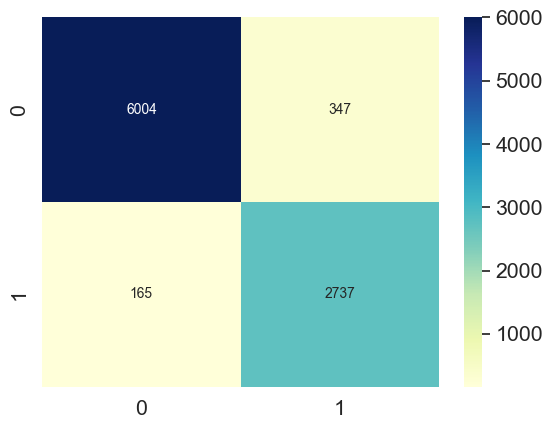

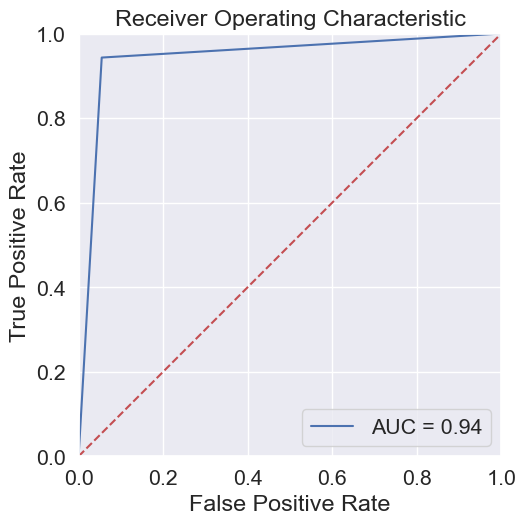

In [87]:
# Predicting the Test set results
y_pred = full_clf.predict(val_input_features.astype(np.float32))

print(metrics.classification_report(val_labels, y_pred))
plot_confusion_matrix(val_labels, y_pred)
plot_roc_curve(val_labels, y_pred)

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(train_input_features, train_labels)
print("Train score:", model.score(train_input_features, train_labels))
print("Validation score:", model.score(val_input_features, val_labels))

In [ ]:
# Predicting the Test set results
y_pred = model.predict(val_input_features)

#print the classification report to highlight the accuracy with f1-score, precision and recall
print(metrics.classification_report(val_labels, y_pred))
plot_confusion_matrix(val_labels, y_pred)
plot_roc_curve(val_labels, y_pred)

## Complement Naive Bayes
Good for imbalanced datasets

In [ ]:
from sklearn.naive_bayes import ComplementNB

model = ComplementNB()
model.fit(train_input_features, train_labels)
print("Train score:", model.score(train_input_features, train_labels))
print("Validation score:", model.score(val_input_features, val_labels))

In [ ]:
# Predicting the Test set results
y_pred = model.predict(val_input_features)

#print the classification report to highlight the accuracy with f1-score, precision and recall
print(metrics.classification_report(val_labels, y_pred))
plot_confusion_matrix(val_labels, y_pred)
plot_roc_curve(val_labels, y_pred)

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(train_input_features, train_labels)
print("Train score:", model.score(train_input_features, train_labels))
print("Validation score:", model.score(val_input_features, val_labels))

In [ ]:
# Predicting the Test set results
y_pred = model.predict(val_input_features)

#print the classification report to highlight the accuracy with f1-score, precision and recall
print(metrics.classification_report(val_labels, y_pred))
plot_confusion_matrix(val_labels, y_pred)
plot_roc_curve(val_labels, y_pred)

## Voting Classifier

# Deep Learning Related/Unrelated Model

In [88]:
device = "cuda"

In [89]:
create_classifier_model = lambda inp_dim: nn.Sequential(*[
    nn.Linear(inp_dim, 1024),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(128, 1)
])

In [90]:
inp_dim = train_input_features.shape[1]

In [91]:
classifier_model = create_classifier_model(inp_dim).to(device)

In [92]:
classifier_model

Sequential(
  (0): Linear(in_features=52850, out_features=1024, bias=True)
  (1): Dropout(p=0.2, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=1024, out_features=512, bias=True)
  (4): Dropout(p=0.2, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=512, out_features=256, bias=True)
  (7): Dropout(p=0.2, inplace=False)
  (8): ReLU()
  (9): Linear(in_features=256, out_features=128, bias=True)
  (10): Dropout(p=0.2, inplace=False)
  (11): ReLU()
  (12): Linear(in_features=128, out_features=1, bias=True)
)

In [93]:
torchsummary.summary(classifier_model, (inp_dim,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]      54,119,424
           Dropout-2                 [-1, 1024]               0
              ReLU-3                 [-1, 1024]               0
            Linear-4                  [-1, 512]         524,800
           Dropout-5                  [-1, 512]               0
              ReLU-6                  [-1, 512]               0
            Linear-7                  [-1, 256]         131,328
           Dropout-8                  [-1, 256]               0
              ReLU-9                  [-1, 256]               0
           Linear-10                  [-1, 128]          32,896
          Dropout-11                  [-1, 128]               0
             ReLU-12                  [-1, 128]               0
           Linear-13                    [-1, 1]             129
Total params: 54,808,577
Trainable para

In [94]:
unique_class_labels = np.unique(train_labels)
class_weights = compute_class_weight("balanced", classes=unique_class_labels, y=train_labels)
class_weights = torch.from_numpy(class_weights)
class_weights

tensor([0.6743, 1.9344], dtype=torch.float64)

In [95]:
# loss_func = nn.BCELoss()
opt = optim.Adam(classifier_model.parameters(), lr=1e-3)

In [96]:
batch_size = 64
apply_loss_weighting = False

In [97]:
coo = train_input_features.tocoo()
train_input_features_tensor = torch.sparse.FloatTensor(torch.LongTensor(np.vstack((coo.row, coo.col))), torch.FloatTensor(coo.data), torch.Size(coo.shape))
train_labels_tensor = torch.FloatTensor(train_labels).unsqueeze(1)

In [98]:
coo = val_input_features.tocoo()
val_input_features_tensor = torch.sparse.FloatTensor(torch.LongTensor(np.vstack((coo.row, coo.col))), torch.FloatTensor(coo.data), torch.Size(coo.shape))
val_labels_tensor = torch.FloatTensor(val_labels).unsqueeze(1)

In [99]:
tfidf_train_dataset = torch.utils.data.TensorDataset(train_input_features_tensor, train_labels_tensor)
tfidf_train_dataloader = torch.utils.data.DataLoader(tfidf_train_dataset, batch_size=batch_size, shuffle=True)

In [100]:
tfidf_val_dataset = torch.utils.data.TensorDataset(val_input_features_tensor, val_labels_tensor)
tfidf_val_dataloader = torch.utils.data.DataLoader(tfidf_val_dataset, batch_size=batch_size * 32, shuffle=False)

In [101]:
def evaluate_model(model, dataloader, labels, apply_loss_weighting):
    if not apply_loss_weighting:
        loss_func = nn.BCEWithLogitsLoss()
    
    with torch.no_grad():
        model.eval()
        
        all_pred = np.array([])
        total_loss = 0
        
        for inp, labels in tqdm(dataloader):
            inp = inp.to_dense().to(device)
            labels = labels.to(device)
            
            loss_weights = torch.zeros_like(labels)
            loss_weights[labels == 0] = class_weights[0]
            loss_weights[labels == 1] = class_weights[1]
            loss_func = nn.BCEWithLogitsLoss(weight=loss_weights)
        
            pred = model(inp)
            loss = loss_func(pred, labels.float())
            pred = torch.sigmoid(pred)
            
            all_pred = np.concatenate([all_pred, pred.cpu().round().numpy().squeeze()])
            total_loss += loss.item()
        
        model.train()
    
    return all_pred, total_loss / len(dataloader)

  0%|          | 0/637 [00:00<?, ?it/s]

[1:40] Loss: 0.579
[1:80] Loss: 0.494
[1:120] Loss: 0.470
[1:160] Loss: 0.392
[1:200] Loss: 0.307
[1:240] Loss: 0.264
[1:280] Loss: 0.191
[1:320] Loss: 0.195
[1:360] Loss: 0.151
[1:400] Loss: 0.143
[1:440] Loss: 0.131
[1:480] Loss: 0.127
[1:520] Loss: 0.096
[1:560] Loss: 0.086
[1:600] Loss: 0.088
[1:END] Took 181.539s
[1:END] Training Loss: 0.004


  0%|          | 0/5 [00:00<?, ?it/s]

[1:END] Validation Loss: 0.153
[1:END] Validation Accuracy: 93.008%
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      6351
           1       0.83      0.97      0.90      2902

    accuracy                           0.93      9253
   macro avg       0.91      0.94      0.92      9253
weighted avg       0.94      0.93      0.93      9253



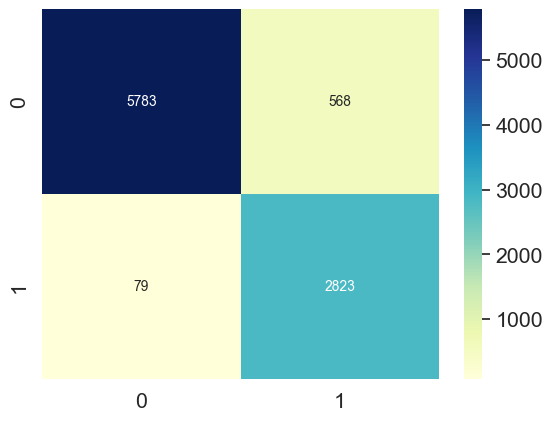

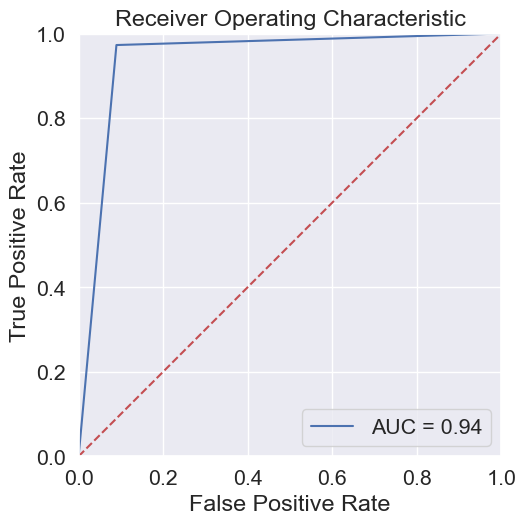

[1:END] Validation loss improved, saved model to ./runs/1678816441.1977248_no_weight/model_1.pth


  0%|          | 0/637 [00:00<?, ?it/s]

[2:40] Loss: 0.049
[2:80] Loss: 0.045
[2:120] Loss: 0.054
[2:160] Loss: 0.039
[2:200] Loss: 0.052
[2:240] Loss: 0.051
[2:280] Loss: 0.044
[2:320] Loss: 0.048
[2:360] Loss: 0.033
[2:400] Loss: 0.050
[2:440] Loss: 0.033
[2:480] Loss: 0.027
[2:520] Loss: 0.041
[2:560] Loss: 0.046
[2:600] Loss: 0.048
[2:END] Took 180.959s
[2:END] Training Loss: 0.001


  0%|          | 0/5 [00:00<?, ?it/s]

[2:END] Validation Loss: 0.105
[2:END] Validation Accuracy: 96.801%
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      6351
           1       0.94      0.96      0.95      2902

    accuracy                           0.97      9253
   macro avg       0.96      0.97      0.96      9253
weighted avg       0.97      0.97      0.97      9253



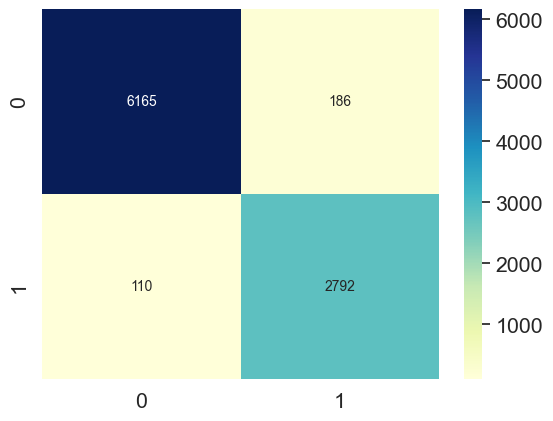

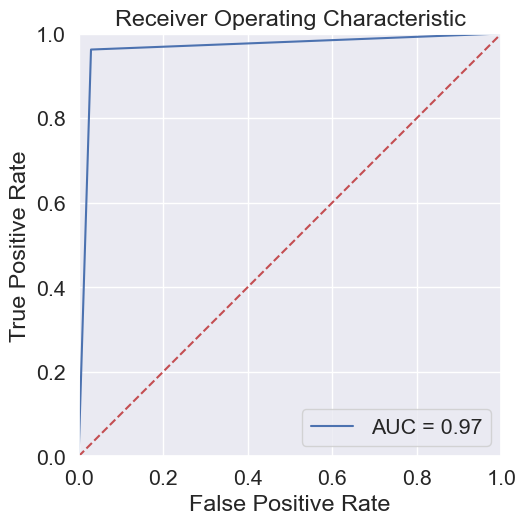

[2:END] Validation loss improved, saved model to ./runs/1678816441.1977248_no_weight/model_2.pth


  0%|          | 0/637 [00:00<?, ?it/s]

[3:40] Loss: 0.025
[3:80] Loss: 0.015
[3:120] Loss: 0.015
[3:160] Loss: 0.015
[3:200] Loss: 0.017
[3:240] Loss: 0.014
[3:280] Loss: 0.022
[3:320] Loss: 0.022
[3:360] Loss: 0.013
[3:400] Loss: 0.018
[3:440] Loss: 0.020
[3:480] Loss: 0.016
[3:520] Loss: 0.016
[3:560] Loss: 0.018
[3:600] Loss: 0.018
[3:END] Took 182.450s
[3:END] Training Loss: 0.000


  0%|          | 0/5 [00:00<?, ?it/s]

[3:END] Validation Loss: 0.120
[3:END] Validation Accuracy: 94.413%
              precision    recall  f1-score   support

           0       0.99      0.92      0.96      6351
           1       0.86      0.99      0.92      2902

    accuracy                           0.94      9253
   macro avg       0.93      0.96      0.94      9253
weighted avg       0.95      0.94      0.95      9253



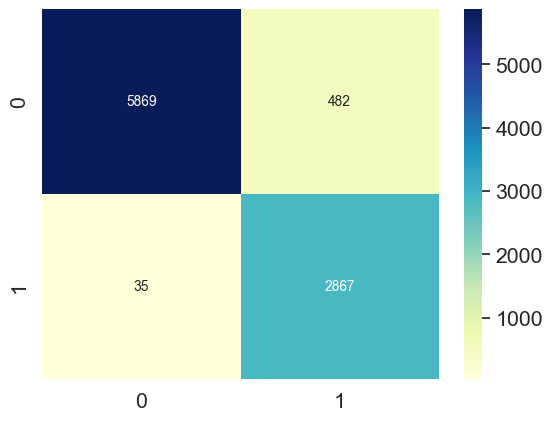

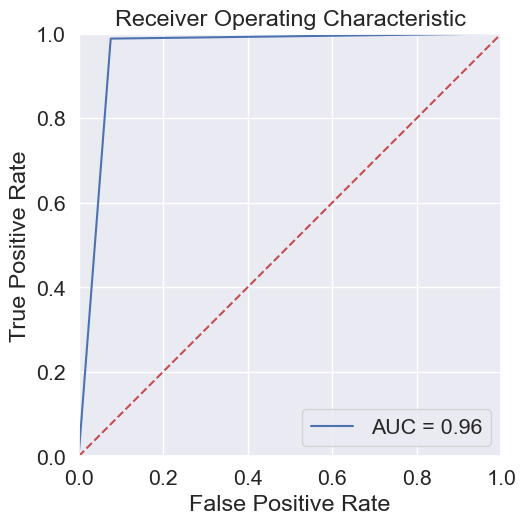

  0%|          | 0/637 [00:00<?, ?it/s]

[4:40] Loss: 0.011
[4:80] Loss: 0.004
[4:120] Loss: 0.007
[4:160] Loss: 0.005
[4:200] Loss: 0.014
[4:240] Loss: 0.006
[4:280] Loss: 0.010
[4:320] Loss: 0.010
[4:360] Loss: 0.007
[4:400] Loss: 0.007
[4:440] Loss: 0.002
[4:480] Loss: 0.011
[4:520] Loss: 0.008
[4:560] Loss: 0.004
[4:600] Loss: 0.016
[4:END] Took 181.759s
[4:END] Training Loss: 0.000


  0%|          | 0/5 [00:00<?, ?it/s]

[4:END] Validation Loss: 0.121
[4:END] Validation Accuracy: 96.747%
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      6351
           1       0.93      0.97      0.95      2902

    accuracy                           0.97      9253
   macro avg       0.96      0.97      0.96      9253
weighted avg       0.97      0.97      0.97      9253



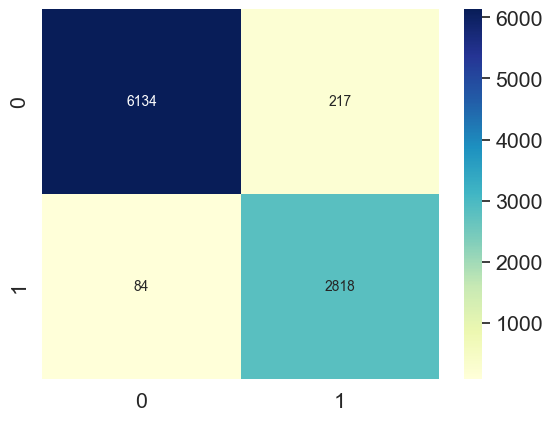

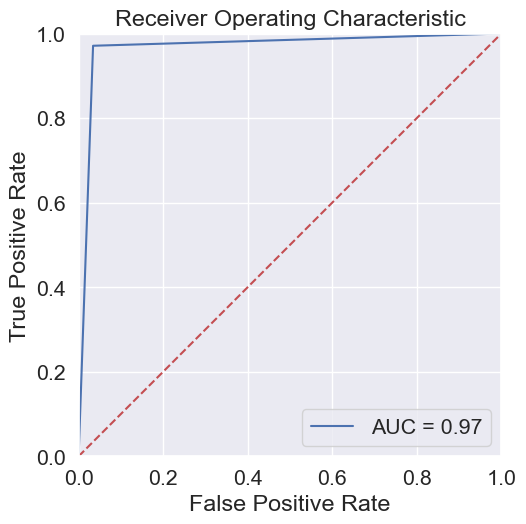

[END] Stopping early as validation loss hasn't improved in 2 epochs
Training complete


In [102]:
best_validation_loss = 1e9
save_path = f"./runs/{time.time()}_{'weighted' if apply_loss_weighting else 'no_weight'}"
epochs_since_best_validation = 0

os.makedirs(save_path, exist_ok=True)

if not apply_loss_weighting:
    loss_func = nn.BCEWithLogitsLoss()

for epoch in range(1, 101):
    epoch_st = time.time()
    epoch_loss = 0
    
    batch_acc_loss = 0
    
    for batch_no, (inp, labels) in enumerate(tqdm(tfidf_train_dataloader)):
        inp = inp.to_dense().to(device)
        labels = labels.to(device)
        
        if apply_loss_weighting:
            loss_weights = torch.zeros_like(labels)
            loss_weights[labels == 0] = class_weights[0]
            loss_weights[labels == 1] = class_weights[1]
            loss_func = nn.BCEWithLogitsLoss(weight=loss_weights)
        
        predictions = classifier_model(inp)
        loss = loss_func(predictions, labels.float())
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        epoch_loss += loss.item()
        batch_acc_loss += loss.item()
        
        if batch_no != 0 and batch_no % 40 == 0:
            print(f"[{epoch}:{batch_no}] Loss: {(batch_acc_loss / 40):.3f}")
            batch_acc_loss = 0
    
    epoch_dt = time.time() - epoch_st
    print(f"[{epoch}:END] Took {epoch_dt:.3f}s")
    print(f"[{epoch}:END] Training Loss: {(epoch_loss / len(tfidf_train_dataloader)):.3f}")
    
    validation_pred, avg_validation_loss = evaluate_model(classifier_model, tfidf_val_dataloader, val_labels, apply_loss_weighting)
    print(f"[{epoch}:END] Validation Loss: {avg_validation_loss:.3f}")
    print(f"[{epoch}:END] Validation Accuracy: {(validation_pred == val_labels).mean() * 100:.3f}%")
    
    print(metrics.classification_report(val_labels, validation_pred))
    plot_confusion_matrix(val_labels, validation_pred)
    plot_roc_curve(val_labels, validation_pred)
    
    epochs_since_best_validation += 1
    
    if avg_validation_loss < best_validation_loss:
        epochs_since_best_validation = 0
        best_validation_loss = avg_validation_loss
        torch.save(classifier_model.state_dict(), f"{save_path}/model_{epoch}.pth")
        print(f"[{epoch}:END] Validation loss improved, saved model to {save_path}/model_{epoch}.pth")
    
    if epochs_since_best_validation >= 2:
        print(f"[END] Stopping early as validation loss hasn't improved in 2 epochs")
        break
        
print("Training complete")